In [13]:
import pandas as pd

In [8]:
df = pd.read_hdf('data/metr-la.h5')

In [9]:
df.shape

(34272, 207)

In [11]:
df.columns

Index(['773869', '767541', '767542', '717447', '717446', '717445', '773062',
       '767620', '737529', '717816',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=207)

In [14]:
df.to_numpy()

array([[64.375     , 67.625     , 67.125     , ..., 59.25      ,
        69.        , 61.875     ],
       [62.66666667, 68.55555556, 65.44444444, ..., 55.88888889,
        68.44444444, 62.875     ],
       [64.        , 63.75      , 60.        , ..., 61.375     ,
        69.85714286, 62.        ],
       ...,
       [67.        , 59.66666667, 69.55555556, ..., 63.33333333,
        67.44444444, 61.22222222],
       [66.75      , 62.25      , 66.        , ..., 63.        ,
        67.875     , 63.5       ],
       [65.11111111, 66.88888889, 66.77777778, ..., 63.55555556,
        68.66666667, 61.77777778]])

In [19]:
loc_df = pd.read_csv('data/sensor_graph/state_location.csv')

In [53]:
loc_df_2 = pd.DataFrame({})
from_list = []
to_list = [] 
cost_list = []

for i in list(loc_df['id'].index):
    from_lat, from_lon = loc_df.loc[i,'latitude'], loc_df.loc[i,'longitude']
    
    for j in list(loc_df['id'].index):
        from_list.append(loc_df.loc[i,'id'])
        to_list.append(loc_df.loc[j,'id'])
        
        to_lat, to_lon = loc_df.loc[j,'latitude'], loc_df.loc[j,'longitude']
        
        # cost calculate #
        tmp = np.array([from_lat, from_lon]) - np.array([to_lat, to_lon])
        L2_norm = np.linalg.norm(tmp, 2)
        
        cost_list.append(L2_norm)
        
print(len(from_list), len(to_list), len(cost_list))
loc_df_2['from'] = from_list
loc_df_2['to'] = to_list
loc_df_2['cost'] = cost_list

289 289 289


In [64]:
loc_df_2.to_csv('distances_kr_state.csv')
df = pd.read_csv('con_state.csv', index_col='Date')
df.transpose().to_csv('state-kr.csv')

In [79]:
import scipy.sparse as sp
from sensors2graph import *

with open('/Users/jeonjunhwi/문서/Projects/Master_GNN/gnn강의-자료/코드/최종 프로젝트 3/Pytorch/stgcn_wave/data/sensor_graph/state.txt') as f:
    sensor_ids = f.read().strip().split(',')
distance_df = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/gnn강의-자료/코드/최종 프로젝트 3/Pytorch/stgcn_wave/data/sensor_graph/distances_kr_state.csv', dtype={'from': 'str', 'to': 'str'}, index_col=0)

In [81]:
get_adjacency_matrix(distance_df, sensor_ids) #Generates the adjacent matrix from the distance between sensors and the sensor ids. 

array([[1.        , 0.91712916, 0.57187015, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.25539863,
        0.        , 0.        , 0.27451196, 0.        , 0.1771712 ,
        0.        , 0.30302992],
       [0.91712916, 1.        , 0.76858085, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.34864458,
        0.        , 0.        , 0.27420256, 0.20841792, 0.18368685,
        0.        , 0.24262348],
       [0.57187015, 0.76858085, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.7114548 ,
        0.        , 0.        , 0.43658465, 0.42979428, 0.3472461 ,
        0.        , 0.28290194],
       [0.        , 0.        , 0.        , 1.        , 0.6212964 ,
        0.6075385 , 0.12176067, 0.        , 0.41003618, 0.2280027 ,
        0.        , 0.        , 0.57404757, 0.        , 0.6631905 ,
        0.        , 0.6023734 ],
       [0.        , 0.        , 0.        , 0.621296

In [14]:
df = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/gnn강의-자료/코드/최종 프로젝트 3/Pytorch/stgcn_wave/data/state-kr.csv', index_col=0)

In [85]:
num_samples, num_nodes = df.shape
len_val = round(num_samples * 0.1)
len_train = round(num_samples * 0.7)
train = df[: len_train]
val = df[len_train: len_train + len_val]
test = df[len_train + len_val:]

In [86]:
train.shape

(402, 17)

In [87]:
val.shape

(58, 17)

In [88]:
test.shape

(115, 17)

In [21]:
for col in list(df.columns):
    df[col] = df[col]/df[col].max()

In [24]:
df.to_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/gnn강의-자료/코드/최종 프로젝트 3/Pytorch/stgcn_wave/data/state-kr-col_normalized.csv', encoding='euc-kr')

In [28]:
df = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/gnn강의-자료/코드/최종 프로젝트 3/Pytorch/stgcn_wave/data/sensor_graph/distances_kr_state.csv', encoding='euc-kr', index_col=0)

In [34]:
df

,from,to,cost
0,2,2,0.000000
1,2,3,1.627221
2,2,5,2.296710
3,2,9,0.574033
4,2,16,1.105496
...,...,...,...
284,15,11,0.429305
285,15,14,2.091458
286,15,6,0.793925
287,15,4,2.486938


In [49]:
pre_row = df['from'][0]
node_list = [pre_row]
for row in df.values:
    # print(row[0], row[1])
    if pre_row != row[0]:
        node_list.append(row[0])
    pre_row = row[0]

node_list

[2,
 3.0,
 5.0,
 9.0,
 16.0,
 7.0,
 8.0,
 10.0,
 13.0,
 1.0,
 0.0,
 12.0,
 11.0,
 14.0,
 6.0,
 4.0,
 15.0]

In [51]:
adj = [[1,2,3],
 [2,3,4],
 [4,5,6]]

pd.DataFrame(adj, columns=[str(i) for i in range(3)], index=[str(i) for i in range(3)])

,0,1,2
0,1,2,3
1,2,3,4
2,4,5,6


In [61]:
df = pd.read_csv('data/R_state.csv', index_col='date').transpose()

In [66]:
df = df.reindex(columns=[i for i in range(17)])
df.to_csv('data/state_kr-R.csv')

In [28]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1))#, nn.Sigmoid())
        self.fc = nn.Linear(hidden_size*sequence_length, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0],self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size()[0],self.hidden_size).to(self.device)
        out,_ = self.lstm(x, (h0, c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out
    
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(GRU, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1))#, nn.Sigmoid())
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0],self.hidden_size).to(self.device)
        out,_ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out
    
def validaion_loss(dataloader, model):
    n = len(dataloader)
    running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
    model.train()
    return running_loss / n

def seq_data(data,sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(data) - sequence_length):
        x_seq.append(data[i:i+sequence_length])
        y_seq.append(data[i+sequence_length])
        
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)



def train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer, model, save_path):
    # criterion = nn.MSELoss()
    # num_epochs = 301
    # optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # save_path = f"save_model/{i}.pt"
    loss_graph = []
    min_val_loss = 0.5 # 대에충
    n = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for data in train_loader:
            
            seq, target = data
            out = model(seq)
            loss = criterion(out, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        loss_graph.append(running_loss/n)
        val_loss = validaion_loss(val_loader, model)
        
        # Model save
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
        
        # Print training process
        if epoch % 100 == 0:
            print('[epoch : %d] train_loss : %.4f val_loss : %.4f'%(epoch, running_loss/n, val_loss))
            

def test_rnn(model, test_loader):
    with torch.no_grad():
        pred = []
        model.eval()
        for data in test_loader:
            seq, target = data
            out = model(seq)
            pred += out.cpu().tolist()
    return pred

cpu
[epoch:0] train_loss: 1.8677 val_loss : 0.6373
[epoch:100] train_loss: 0.1558 val_loss : 0.0077
[epoch:200] train_loss: 0.1488 val_loss : 0.0091
[epoch:0] train_loss: 1.6625 val_loss : 0.6686
[epoch:100] train_loss: 0.1545 val_loss : 0.0071
[epoch:200] train_loss: 0.1526 val_loss : 0.0084
[epoch:0] train_loss: 0.9610 val_loss : 0.4453
[epoch:100] train_loss: 0.0265 val_loss : 0.0019
[epoch:200] train_loss: 0.0195 val_loss : 0.0004
[epoch:0] train_loss: 0.8543 val_loss : 0.5531
[epoch:100] train_loss: 0.0262 val_loss : 0.0007
[epoch:200] train_loss: 0.0262 val_loss : 0.0005
[epoch:0] train_loss: 0.8958 val_loss : 0.3268
[epoch:100] train_loss: 0.0184 val_loss : 0.0013
[epoch:200] train_loss: 0.0177 val_loss : 0.0009
[epoch:0] train_loss: 0.5872 val_loss : 0.3256
[epoch:100] train_loss: 0.0190 val_loss : 0.0025
[epoch:200] train_loss: 0.0170 val_loss : 0.0014
[epoch:0] train_loss: 3.5156 val_loss : 1.0181
[epoch:100] train_loss: 0.4177 val_loss : 0.0116
[epoch:200] train_loss: 0.4058

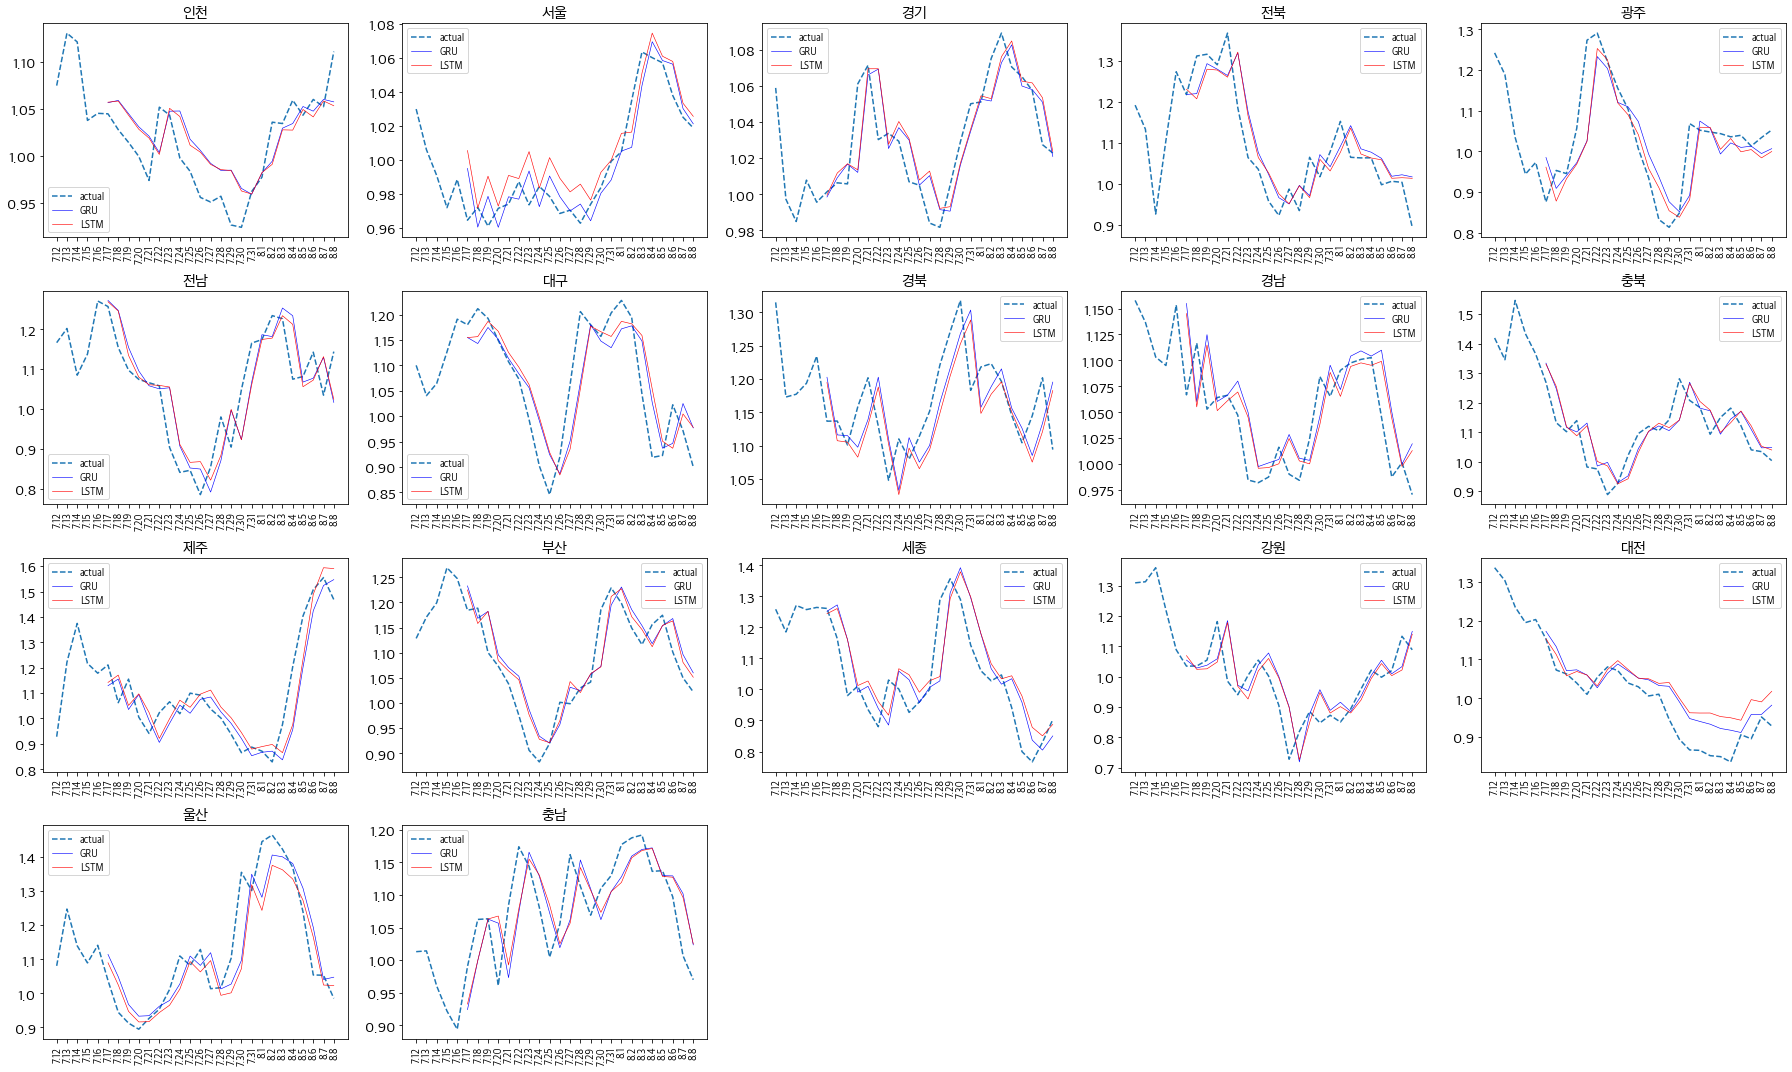

In [29]:
# plot에서 한글 폰트 깨지는 현상 해결!
from matplotlib import font_manager, rc
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family = font)

df = pd.read_csv('data/state-kr-R.csv', index_col=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

enc = {0: '인천',
        1: '서울',
        2: '경기',
        3: '전북',
        4: '광주',
        5: '전남',
        6: '대구',
        7: '경북',
        8: '경남',
        9: '충북',
        10: '제주',
        11: '부산',
        12: '세종',
        13: '강원',
        14: '대전',
        15: '울산',
        16: '충남'}


len_train = round(len(df)*0.85)
len_val = round(len(df)*0.1)
sequence_length = 5
fig = plt.figure(figsize=(25,15))
for i in list(df.columns):
# for i in ['0', '1']:
    x_seq, y_seq = seq_data(df[[i]].values, sequence_length)

    x_train_seq = x_seq[:len_train]
    y_train_seq = y_seq[:len_train]

    x_val_seq = x_seq[len_train:len_train+len_val]
    y_val_seq = y_seq[len_train:len_train+len_val]

    x_test_seq = x_seq[len_train+len_val:]
    y_test_seq = y_seq[len_train+len_val:]

    # print(x_train_seq.shape, y_train_seq.shape)
    # print(x_val_seq.shape, y_val_seq.shape)
    # print(x_test_seq.shape, y_test_seq.shape)

    train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
    val = torch.utils.data.TensorDataset(x_val_seq, y_val_seq)
    test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
    batch_size = 16
    train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

    input_size = x_seq.size(2)
    num_layers = 2
    hidden_size = 8

    model_1 = GRU(input_size = input_size,
                    hidden_size = hidden_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)
    
    model_2 = LSTM(input_size = input_size,
                    hidden_size = hidden_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)

    criterion = nn.MSELoss()
    num_epochs = 201
    optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
    
    # model_1 = train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer_1, model_1, i)
    # model_2 = train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer_2, model_2, i)
    save_path_1 = f"save_model/gru_{i}.pt"
    save_path_2 = f"save_model/lstm{i}.pt"
    train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer_1, model_1, save_path_1)
    train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer_2, model_2, save_path_2)
    
    best_model_1 = GRU(input_size = input_size,
                    hidden_size = hidden_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)
    best_model_1.load_state_dict(torch.load(save_path_1))
    
    best_model_2 = LSTM(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers,
                device = device).to(device)
    best_model_2.load_state_dict(torch.load(save_path_2))

    pred_1 = test_rnn(best_model_1, test_loader)
    pred_2 = test_rnn(best_model_2, test_loader)

    pred_1 = [[None]]*sequence_length + pred_1 # y 값은 5일 학습하고 다음날을 예측한 것이므로, shift 해줘야함
    pred_2 = [[None]]*sequence_length + pred_2
    
    fig.add_subplot(4,5,int(i)+1)
    plt.plot(df[i][len_train + len_val:].values,'--')
    plt.plot(pred_1,'b',linewidth=0.6)
    plt.plot(pred_2,'r',linewidth=0.6)
    plt.legend(['actual', 'GRU', 'LSTM'])
    
    # xlabels = list(df.index[len_train + len_val:])
    xlabels = [i[5:] for i in list(df.index[len_train + len_val:])]
    plt.xticks(ticks = [i for i in range(len(xlabels))], labels = xlabels, rotation=90)
    plt.yticks(fontsize = 15)
    plt.title(enc[int(i)], fontsize = 15)
    plt.tight_layout()

plt.savefig('Figures/compare_rnn.png')